# Smart Pricing for Used Car Dataset
  - In this notebook I will show how to create a model for predicting the sale price of a used car on craigslist.
  - This model could be used by craiglist for suggesting what a user might list their car for, but also by a user to ensure they are getting a good deal on a used car.

### helpful links
  - Kaggle Dataset - https://www.kaggle.com/austinreese/craigslist-carstrucks-data
  - Craiglist Scraper - https://github.com/AustinReese/craigslistFilter
  - Notebooks that inspired this post
      - https://www.kaggle.com/vbmokin/used-cars-fe-eda-with-3d-abnormals-filter
      - https://www.kaggle.com/jrw2200/smart-pricing-with-xgb-rfr-interpretations
      - https://www.kaggle.com/vbmokin/automatic-selection-from-20-classifier-models
      - https://www.kaggle.com/aantonova/some-new-risk-and-clusters-features

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly as py
import plotly.graph_objs as go
from plotly.subplots import make_subplots

init_notebook_mode(connected=True)

import collections
import itertools

import scipy.stats as stats
from scipy.stats import norm
from scipy.special import boxcox1p

import statsmodels
import statsmodels.api as sm
#print(statsmodels.__version__)

from sklearn.preprocessing import scale, StandardScaler, RobustScaler, OneHotEncoder, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold, StratifiedKFold, RandomizedSearchCV
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV, LinearRegression, ElasticNet,  HuberRegressor
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBRegressor, plot_importance, DMatrix
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.kernel_ridge import KernelRidge
from sklearn.utils import resample


from xgboost import XGBRegressor

#Model interpretation modules
import eli5
import lime
import lime.lime_tabular
import shap
shap.initjs()

Using TensorFlow backend.


# 1.0 Data Ingress
 - Load in the data with pandas and look at some of the features
 - We will perform some minor preprocessing steps that will be necessary later

## 1.1 Open and look at the dataset

In [2]:
car_data = pd.read_csv("vehicles.csv")

In [3]:
print('Number of features: {}'.format(car_data.shape[1]))
print('Number of examples: {}'.format(car_data.shape[0]))

Number of features: 25
Number of examples: 509577


In [4]:
# data types
car_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 509577 entries, 0 to 509576
Data columns (total 25 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            509577 non-null  int64  
 1   url           509577 non-null  object 
 2   region        509577 non-null  object 
 3   region_url    509577 non-null  object 
 4   price         509577 non-null  int64  
 5   year          508050 non-null  float64
 6   manufacturer  486813 non-null  object 
 7   model         501588 non-null  object 
 8   condition     277643 non-null  object 
 9   cylinders     309894 non-null  object 
 10  fuel          505592 non-null  object 
 11  odometer      417253 non-null  float64
 12  title_status  506515 non-null  object 
 13  transmission  505858 non-null  object 
 14  vin           302152 non-null  object 
 15  drive         365434 non-null  object 
 16  size          167574 non-null  object 
 17  type          368046 non-null  object 
 18  pain

## 1.2 Drop unhelpful columns
  - Some of the columns won't help us make any decisions about the data so we will just drop them for now

In [5]:
drop_columns = ['url', 'region', 'region_url', 'title_status', 'vin', 'size', 'image_url', 'description', 'lat','long', 'paint_color', "county"]
data = car_data.drop(columns=drop_columns)
data = data.dropna()

In [6]:
print('Number of features: {}'.format(data.shape[1]))
print('Number of examples: {}'.format(data.shape[0]))

Number of features: 13
Number of examples: 154377


## 1.3 Why you should hangout on Kaggle
  - these are two helpful functions for prepping data for a regression algorithm
  - the first performs encoding of catagorical features
  - the second is a fancy lil function to reduce the memory usage of a dataset by converting to numpy datatypes(awesome)

In [7]:
# from the kernel: https://www.kaggle.com/vbmokin/automatic-selection-from-20-classifier-models
# Determination categorical features
numerics = ['int8', 'int16', 'int32', 'int64', 'float16', 'float32', 'float64']
categorical_columns = []
features = data.columns.values.tolist()
for col in features:
    if data[col].dtype in numerics: continue
    categorical_columns.append(col)
# Encoding categorical features
for col in categorical_columns:
    if col in data.columns:
        le = LabelEncoder()
        le.fit(list(data[col].astype(str).values))
        data[col] = le.transform(list(data[col].astype(str).values))

In [8]:
# Thanks to : https://www.kaggle.com/aantonova/some-new-risk-and-clusters-features
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [9]:
data = reduce_mem_usage(data)

Mem. usage decreased to  5.89 Mb (64.3% reduction)


In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 154377 entries, 0 to 509564
Data columns (total 13 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            154377 non-null  int64  
 1   price         154377 non-null  int64  
 2   year          154377 non-null  float16
 3   manufacturer  154377 non-null  int8   
 4   model         154377 non-null  int16  
 5   condition     154377 non-null  int8   
 6   cylinders     154377 non-null  int8   
 7   fuel          154377 non-null  int8   
 8   odometer      154377 non-null  float32
 9   transmission  154377 non-null  int8   
 10  drive         154377 non-null  int8   
 11  type          154377 non-null  int8   
 12  state         154377 non-null  int8   
dtypes: float16(1), float32(1), int16(1), int64(2), int8(8)
memory usage: 5.9 MB


In [11]:
data.head()

id  price    year  manufacturer  model  condition  cylinders  \
0   7034441763  17899  2012.0            41   7405          0          3   
24  7034278551   4600  2008.0            17   3393          2          3   
48  7033720842  28000  2004.0            13   6633          2          0   
52  7032995718  18999  2015.0            27   3548          0          3   
53  7032995571  79997  2016.0            27   2118          0          6   

    fuel  odometer  transmission  drive  type  state  
0      2   63500.0             1      0     4     44  
24     2  110982.0             0      1     9     44  
48     2   67348.0             0      0    10     44  
52     2   37000.0             0      1     9     44  
53     2   28000.0             0      2     3     44

## 1.4 Looking at data distributions
 A QQ plot is one of the easiest ways to look at the distibution of your data with respect to some know distribution. In this case we are comparing the sample data to a normal distribution. We take the log of each
price(technically np.log1p() for accuracy with small values) and plot the quantiles against a normal distribution.

Here we see that there is a concentration of low prices that makes this distribution not quite normal. we should filter out some of the lower values in prices so that our distribution is closer to normal.

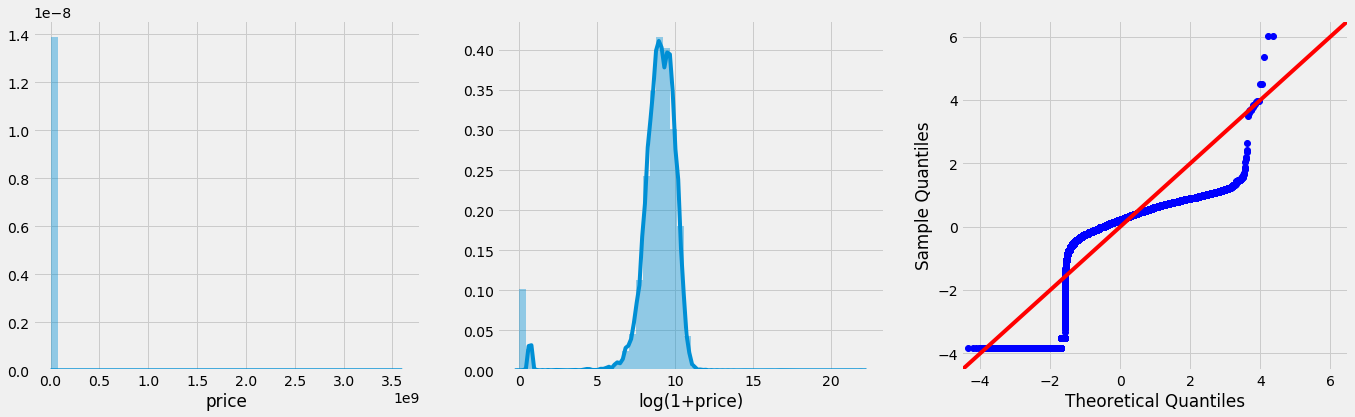

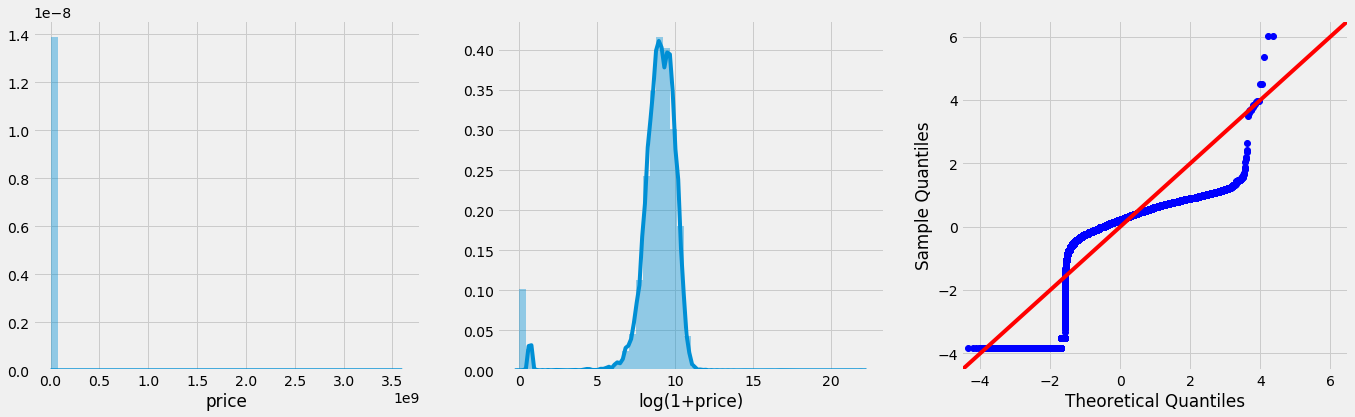

In [34]:
fig, axes = plt.subplots(1,3, figsize=(21,6))
sns.distplot(data['price'], ax=axes[0])
sns.distplot(np.log1p(data['price']), ax=axes[1])
axes[1].set_xlabel('log(1+price)')
sm.qqplot(np.log1p(data['price']), stats.norm, fit=True, line='45', ax=axes[2])

## 1.5 filter abnormal values from the dataset
    - Taken from https://www.kaggle.com/vbmokin/used-cars-fe-eda-with-3d-abnormals-filter

In [12]:
def abnormal_filter(df, threshold_first, threshold_second):
    # Abnormal values filter for DataFrame df:
    # threshold_first (5%-min or max-95%)
    # threshold_second (second diff., times)
    df_describe = df.describe([.05, .1, .9, .95])
    cols = df_describe.columns.tolist()
    i = 0
    abnorm = 0
    for col in cols:
        i += 1
        # abnormal smallest
        P10_5 = df_describe.loc['10%',col]-df_describe.loc['5%',col]
        P_max_min = df_describe.loc['max',col]-df_describe.loc['min',col]
        if P10_5 != 0:
            if (df_describe.loc['5%',col]-df_describe.loc['min',col])/P10_5 > threshold_second:
                #abnormal smallest filter
                df = df[(df[col] >= df_describe.loc['5%',col])]
                print('1: ', i, col, df_describe.loc['min',col],df_describe.loc['5%',col],df_describe.loc['10%',col])
                abnorm += 1
        else:
            if P_max_min > 0:
                if (df_describe.loc['5%',col]-df_describe.loc['min',col])/P_max_min > threshold_first:
                    # abnormal smallest filter
                    df = df[(df[col] >= df_describe.loc['5%',col])]
                    print('2: ', i, col, df_describe.loc['min',col],df_describe.loc['5%',col],df_describe.loc['max',col])
                    abnorm += 1

        
        # abnormal biggest
        P95_90 = df_describe.loc['95%',col]-df_describe.loc['90%',col]
        if P95_90 != 0:
            if (df_describe.loc['max',col]-df_describe.loc['95%',col])/P95_90 > threshold_second:
                #abnormal biggest filter
                df = df[(df[col] <= df_describe.loc['95%',col])]
                print('3: ', i, col, df_describe.loc['90%',col],df_describe.loc['95%',col],df_describe.loc['max',col])
                abnorm += 1
        else:
            if P_max_min > 0:
                if ((df_describe.loc['max',col]-df_describe.loc['95%',col])/P_max_min > threshold_first) & (df_describe.loc['95%',col] > 0):
                    # abnormal biggest filter
                    df = df[(df[col] <= df_describe.loc['95%',col])]
                    print('4: ', i, col, df_describe.loc['min',col],df_describe.loc['95%',col],df_describe.loc['max',col])
                    abnorm += 1
    print('Number of abnormal values =', abnorm)
    return df

In [13]:
norm_data = abnormal_filter(data, .5, 3)
norm_data.info()

3:  2 price 24900.0 30257.399999999354 3600028900.0
1:  3 year 1915.0 1998.0 2002.0
3:  3 year 2016.0 2017.0 2021.0
3:  9 odometer 190001.0 217223.0 10000000.0
Number of abnormal values = 4
<class 'pandas.core.frame.DataFrame'>
Int64Index: 127956 entries, 0 to 509564
Data columns (total 13 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            127956 non-null  int64  
 1   price         127956 non-null  int64  
 2   year          127956 non-null  float16
 3   manufacturer  127956 non-null  int8   
 4   model         127956 non-null  int16  
 5   condition     127956 non-null  int8   
 6   cylinders     127956 non-null  int8   
 7   fuel          127956 non-null  int8   
 8   odometer      127956 non-null  float32
 9   transmission  127956 non-null  int8   
 10  drive         127956 non-null  int8   
 11  type          127956 non-null  int8   
 12  state         127956 non-null  int8   
dtypes: float16(1), float32(1), int16(1

In [21]:
norm_data = norm_data[norm_data["price"] >= 1000]
norm_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 115584 entries, 0 to 509564
Data columns (total 13 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            115584 non-null  int64  
 1   price         115584 non-null  int64  
 2   year          115584 non-null  float16
 3   manufacturer  115584 non-null  int8   
 4   model         115584 non-null  int16  
 5   condition     115584 non-null  int8   
 6   cylinders     115584 non-null  int8   
 7   fuel          115584 non-null  int8   
 8   odometer      115584 non-null  float32
 9   transmission  115584 non-null  int8   
 10  drive         115584 non-null  int8   
 11  type          115584 non-null  int8   
 12  state         115584 non-null  int8   
dtypes: float16(1), float32(1), int16(1), int64(2), int8(8)
memory usage: 4.4 MB


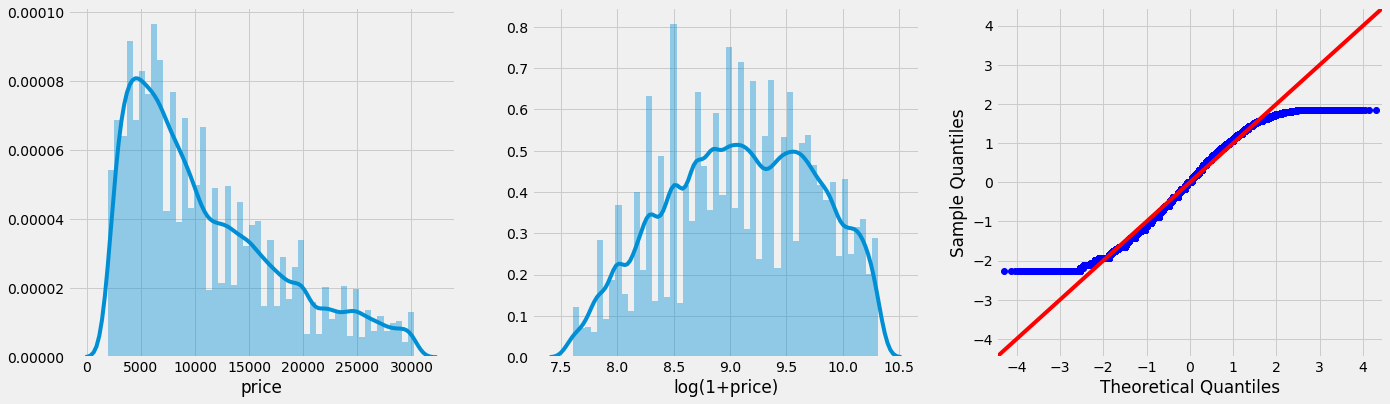

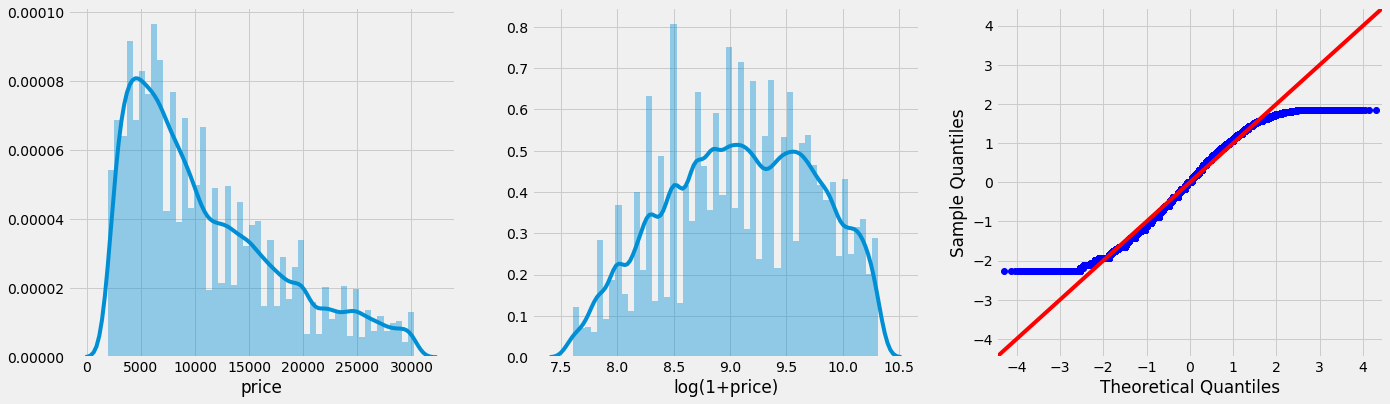

In [33]:
fig, axes = plt.subplots(1,3, figsize=(21,6))
sns.distplot(norm_data['price'], ax=axes[0])
sns.distplot(np.log1p(norm_data['price']), ax=axes[1])
axes[1].set_xlabel('log(1+price)')
sm.qqplot(np.log1p(norm_data['price']), stats.norm, fit=True, line='45', ax=axes[2])

In [57]:
norm_data["price"] = np.log1p(norm_data["price"])
norm_data["odometer"] = np.log1p(norm_data["odometer"])
norm_data.head()

id      price    year  manufacturer  model  condition  cylinders  \
0   7034441763   9.792556  2012.0            41   7405          0          3   
24  7034278551   8.434029  2008.0            17   3393          2          3   
48  7033720842  10.239996  2004.0            13   6633          2          0   
52  7032995718   9.852194  2015.0            27   3548          0          3   
54  7032995413   9.852194  2013.0             4    690          0          5   

    fuel   odometer  transmission  drive  type  state  
0      2  11.058811             1      0     4     44  
24     2  11.617132             0      1     9     44  
48     2  11.117643             0      0    10     44  
52     2  10.518701             0      1     9     44  
54     2  11.082158             0      2     3     44

## 1.6 Correlations in the data
 So I would expect correlations between mileage(odometer) and price. Lets plot a correlation matrix to see if that is true

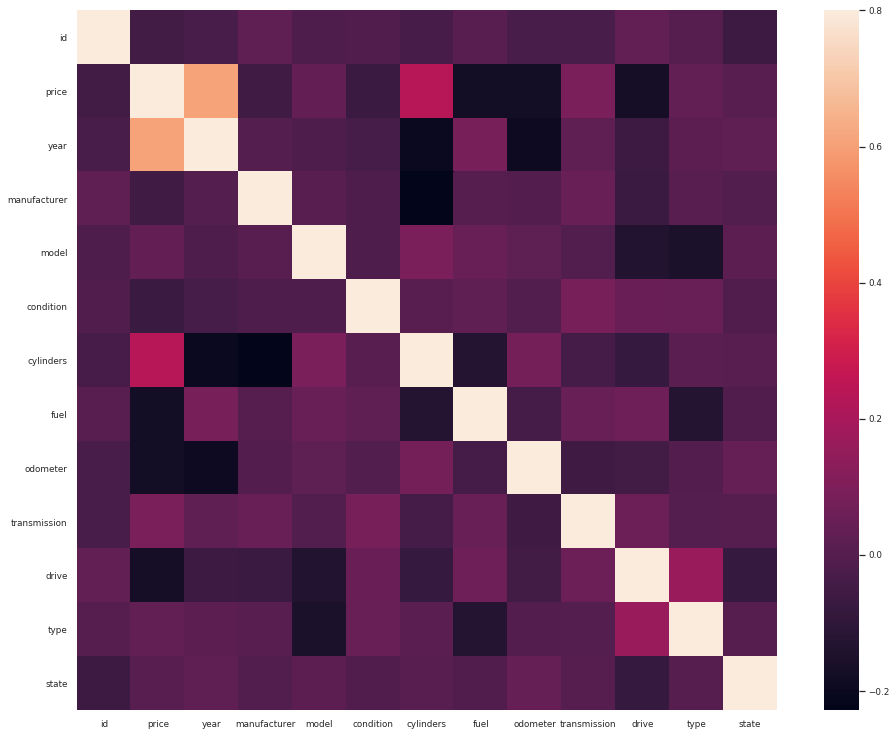

In [58]:
corrmatrix = norm_data.corr()
f, ax = plt.subplots(figsize=(15,12))
sns.heatmap(corrmatrix, vmax=0.8, square=True)
sns.set(font_scale=0.8)

## Correlations
So a few things here.
  - first, negative correlations between price and odometer as well as odometer and year. These both make intuitive     sense as the older the car the more likely it has alot of miles put on it and the more miles, the less the car     is worth in a kelly blue book sense of the word.
  - second, a positive correlation between price and year meaning as the year goes up, the price will go up. This       also makes sense as newer cars are more valuable.
  - lastly a slightly positive correlation between number of cylinders and the price. Cars with V8s, V6s, and
    inline 6s(engine types) are often more valueable than 4 cylinders.
  - Also slightly interesting is that it seems the slightly negative correlation between cylinders and year means
    that newer cars are being made(or at least posted on craigslist) with less cylinders. Yay fuel efficency!

In [59]:
# save the dataset for future use
norm_data.to_csv("filtered_car_data.csv")

# 2.0 Prep data and train regression models
 - Now that we have taken a quick look at the data, we will use a number of regression models to try and create a smart pricing tool for predicting the price of a used vehicle

## 2.1 Prep the dataset for training
  - Drop targets, split dataset, and normalize

In [60]:
prices = norm_data["price"]
sample_data = norm_data.drop(["price", "id"], axis=1)
sample_data.head()

year  manufacturer  model  condition  cylinders  fuel   odometer  \
0   2012.0            41   7405          0          3     2  11.058811   
24  2008.0            17   3393          2          3     2  11.617132   
48  2004.0            13   6633          2          0     2  11.117643   
52  2015.0            27   3548          0          3     2  10.518701   
54  2013.0             4    690          0          5     2  11.082158   

    transmission  drive  type  state  
0              1      0     4     44  
24             0      1     9     44  
48             0      0    10     44  
52             0      1     9     44  
54             0      2     3     44

In [123]:
X_train, X_test, y_train, y_test = train_test_split(sample_data, prices, test_size=0.2, random_state=42)
print('Dimensions of the training feature matrix: {}'.format(X_train.shape))
print('Dimensions of the training target vector: {}'.format(y_train.shape))
print('Dimensions of the test feature matrix: {}'.format(X_test.shape))
print('Dimensions of the test target vector: {}'.format(y_test.shape))

Dimensions of the training feature matrix: (92467, 11)
Dimensions of the training target vector: (92467,)
Dimensions of the test feature matrix: (23117, 11)
Dimensions of the test target vector: (23117,)


In [94]:
scaler = RobustScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

## 2.2 Train with K fold Validation
 - Train multiple models with RMSE loss
 - Use 5-fold validation

In [63]:
n_folds = 5

# squared_loss
def rmse_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=7)
    return cross_val_score(model, X_train, y_train, scoring='neg_mean_squared_error', cv=kf)


In [64]:
for Model in [LinearRegression, Ridge, Lasso, ElasticNet, RandomForestRegressor, XGBRegressor, HuberRegressor]:
    if Model == XGBRegressor:
        cv_res = rmse_cv(XGBRegressor(objective='reg:squarederror'))
    else:
        cv_res = rmse_cv(Model())
    print('{}: {:.5f} +/- {:5f}'.format(Model.__name__, -cv_res.mean(), cv_res.std()))

LinearRegression: 0.18826 +/- 0.002423
Ridge: 0.18826 +/- 0.002423
Lasso: 0.43411 +/- 0.002187
ElasticNet: 0.43411 +/- 0.002187
RandomForestRegressor: 0.05683 +/- 0.000409
XGBRegressor: 0.05792 +/- 0.000667
HuberRegressor: 0.19153 +/- 0.002877


In [124]:
rf = XGBRegressor()
rf.fit(pd.DataFrame(X_train, columns=sample_data.columns), y_train) #feature names for plot importance
y_train_rf = rf.predict(X_train)
y_test_rf = rf.predict(X_test)
rf_results = pd.DataFrame({'algorithm':['XGBRegressor'],
            'training error': [mean_squared_error(y_train, y_train_rf)],
            'test error': [mean_squared_error(y_test, y_test_rf)],
            'training_r2_score': [r2_score(y_train, y_train_rf)],
            'test_r2_score': [r2_score(y_test, y_test_rf)]})
rf_results

algorithm  training error  test error  training_r2_score  test_r2_score
0  XGBRegressor        0.049121    0.056201           0.886843       0.871336

## 2.3 Using Lime to explain results
  - Here we will use LIME to explain the results of the XGB regressor we found to perform best with the default hyperparameters

In [ ]:
# using lime
explainer = lime.lime_tabular.LimeTabularExplainer(X_train,
                                                   feature_names=sample_data.columns,
                                                   class_names=['price'],
                                                   verbose=True,
                                                   mode='regression')


In [98]:
i=25
exp = explainer.explain_instance(X_test[i], rf.predict, num_features=10)
item = pd.DataFrame(scaler.inverse_transform(X_test[i].reshape(1,-1))[0], index=sample_data.columns)
item.loc['odometer'] = np.expm1(item.loc['odometer'])
item.loc['true_price'] = np.exp(y_test.iloc[i])
item.loc['predicted_price'] = np.exp(exp.local_pred)
item

Intercept 9.210620163414006
Prediction_local [8.32199551]
Right: 8.373275


0
year               -1.333333
manufacturer       -0.318182
model               0.702426
condition           1.000000
cylinders           0.333333
fuel                0.000000
odometer            1.440324
transmission        0.000000
drive              -1.000000
type               -0.888889
state               0.000000
true_price       3501.000000
predicted_price  4113.360069

In [99]:
exp.show_in_notebook(show_table=True)

In [100]:
i=30
exp_2 = explainer.explain_instance(X_test[i], rf.predict, num_features=10)
item = pd.DataFrame(scaler.inverse_transform(X_test[i].reshape(1,-1))[0], index=sample_data.columns)
item.loc['odometer'] = np.expm1(item.loc['odometer'])
item.loc['true_price'] = np.exp(y_test.iloc[i])
item.loc['predicted_price'] = np.exp(exp_2.local_pred)
item

Intercept 8.736085712881229
Prediction_local [9.64197508]
Right: 9.890773


0
year                 1.000000
manufacturer         0.363636
model                0.663695
condition            1.500000
cylinders            0.000000
fuel                 0.000000
odometer            -0.525926
transmission         0.000000
drive               -1.000000
type                -0.888889
state                0.555556
true_price       14501.000000
predicted_price  15397.725415

In [101]:
exp_2.show_in_notebook(show_table=True)

## 2.4 XGB feature importance
 - In basic terms, this graph shows the impact of each feature on the models predictions. The F-Score reflects the number of times that the feature is "split on" in the decision trees within the XGB model. 
 - We see that Model, Odometer and Year are the most important features by a fair amount which goes fairly in line with what we saw in the lime outputs.

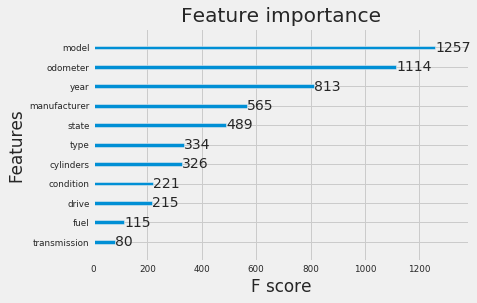

In [126]:
# use the xgb plot importance to see feature importance
plot_importance(rf)

## 3.0 Summary
  - So we were able to get the vehicles dataset processed and into a number of regressors to create a smart pricing tool for used cars.
  - The accuracy of these models could be improved through the use of a hyperparameter optimization tool like HyperOpt
  - We saw that the important features in predicting the price of a used car were Model, number of miles driven, and the year it was made.